In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import cv2 
from matplotlib import pyplot as plt 
import numpy as np 
import json 


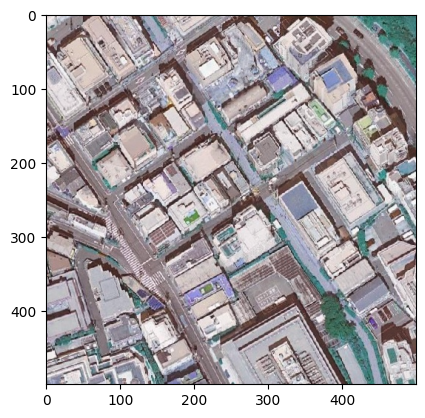

In [3]:
img=cv2.imread(r'/kaggle/input/building-extraction-generalization-2024/train/image/CBD_0001_0_0.jpg')
plt.imshow(img)

## segmentation with detectron2 

In [4]:
#!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

fatal: destination path 'detectron2' already exists and is not an empty directory.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 3.7 MB/s eta 0:00:00
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=6ea04a65c495049d3

In [5]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Nov_22_10:17:15_PST_2023
Cuda compilation tools, release 12.3, V12.3.107
Build cuda_12.3.r12.3/compiler.33567101_0
torch:  2.4 ; cuda:  2.4.0
detectron2: 0.6


In [6]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## train on custom dataset 

In [7]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/kaggle/input/building-extraction-generalization-2024/train/train.json", "/kaggle/input/building-extraction-generalization-2024/train")
register_coco_instances("my_dataset_val", {}, "/kaggle/input/building-extraction-generalization-2024/val/val.json", "/kaggle/input/building-extraction-generalization-2024/val")

train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

[09/26 05:49:59 d2.data.datasets.coco]: Loading /kaggle/input/building-extraction-generalization-2024/train/train.json takes 1.85 seconds.
WARNING [09/26 05:49:59 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/26 05:49:59 d2.data.datasets.coco]: Loaded 3784 images in COCO format from /kaggle/input/building-extraction-generalization-2024/train/train.json
WARNING [09/26 05:50:01 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/26 05:50:01 d2.data.datasets.coco]: Loaded 933 images in COCO format from /kaggle/input/building-extraction-generalization-2024/val/val.json


## train 

In [8]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "/kaggle/working/"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 5  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1500    # 1000 iterations seems good enough for this dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # We have 4 classes.
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available

[09/26 05:50:02 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:00, 216MB/s]                             


In [9]:
trainer.train() #Start the training process

[09/26 05:50:06 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[09/26 05:50:23 d2.utils.events]:  eta: 0:16:23  iter: 19  total_loss: 3.345  loss_cls: 0.59  loss_box_reg: 0.397  loss_mask: 0.6937  loss_rpn_cls: 1.279  loss_rpn_loc: 0.2789    time: 0.6557  last_time: 0.6887  data_time: 0.0264  last_data_time: 0.0139   lr: 4.9953e-06  max_mem: 4473M
[09/26 05:50:49 d2.utils.events]:  eta: 0:16:15  iter: 39  total_loss: 3.005  loss_cls: 0.5684  loss_box_reg: 0.3694  loss_mask: 0.6903  loss_rpn_cls: 0.9502  loss_rpn_loc: 0.3375    time: 0.6623  last_time: 0.6159  data_time: 0.0155  last_data_time: 0.0141   lr: 9.9902e-06  max_mem: 4632M
[09/26 05:51:02 d2.utils.events]:  eta: 0:16:01  iter: 59  total_loss: 2.495  loss_cls: 0.5422  loss_box_reg: 0.4144  loss_mask: 0.683  loss_rpn_cls: 0.5181  loss_rpn_loc: 0.3161    time: 0.6631  last_time: 0.6874  data_time: 0.0180  last_data_time: 0.0135   lr: 1.4985e-05  max_mem: 4679M
[09/26 05:51:16 d2.utils.events]:  eta: 0:15:54  iter: 79  total_loss: 2.319  loss_cls: 0.5008  loss_box_reg: 0.4627  loss_mask: 0.6

In [10]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [11]:

import yaml
# Save the configuration to a config.yaml file
# Save the configuration to a config.yaml file
config_yaml_path = "/kaggle/working/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

## evaluation 

In [12]:

# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[09/26 06:07:54 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/model_final.pth ...


/opt/conda/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

## load the model in case of previously trained

In [13]:
'''cfg = get_cfg()
# Inference should use the config with parameters that are used in training
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join('/kaggle/working/', "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)'''

'cfg = get_cfg()\n# Inference should use the config with parameters that are used in training\ncfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))\n# cfg now already contains everything we\'ve set previously. We changed it a little bit for inference:\ncfg.MODEL.WEIGHTS = os.path.join(\'/kaggle/working/\', "model_final.pth")  # path to the model we just trained\ncfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold\npredictor = DefaultPredictor(cfg)'

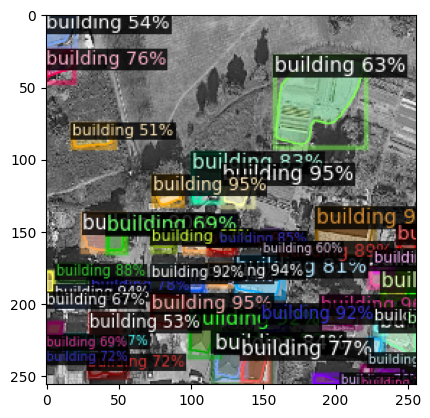

In [40]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
plt.show()

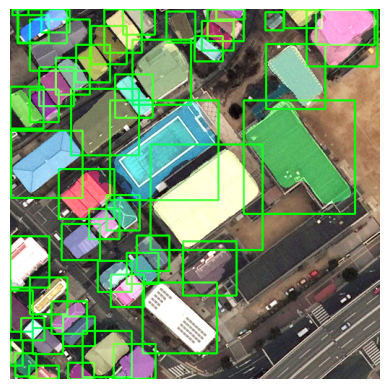

In [24]:

from detectron2.structures import Boxes, Instances


# Define a function to draw bounding boxes
def draw_boxes(image, boxes, color=(0, 255, 0), thickness=2):
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)

# Define a function to draw masks
def draw_masks(image, masks, colors):
    for mask, color in zip(masks, colors):
        # Convert mask to binary image
        mask = mask.astype(np.uint8)
        # Create a color mask
        color_mask = np.zeros_like(image)
        color_mask[mask > 0] = color
        # Blend the color mask with the image
        image = cv2.addWeighted(image, 1.0, color_mask, 0.5, 0)
    return image

# Sample an image from the validation dataset

for d in random.sample(val_dataset_dicts, 1):    # Select number of images for display
    # Read the image
    im = cv2.imread(d["file_name"])

    # Perform inference
    outputs = predictor(im)
    
    # Extract predictions
    instances = outputs["instances"].to("cpu")
    boxes = instances.pred_boxes.tensor.numpy()  # Shape: (N, 4)
    masks = instances.pred_masks.numpy()  # Shape: (N, H, W)
    classes = instances.pred_classes.numpy()  # Shape: (N,)
    
    # Draw bounding boxes
    draw_boxes(im, boxes)
    
    # Define colors for each class
    colors = [(np.random.rand()*255, np.random.rand()*255, np.random.rand()*255) for _ in range(len(masks))]
    
    # Draw segmentation masks
    im = draw_masks(im, masks, colors)
    
    # Display the image with predictions
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))  # Convert from BGR to RGB
    plt.axis('off')  # Hide axis
    plt.show()  # Show the image


In [25]:
outputs = predictor(im)

In [26]:
from detectron2.structures import Boxes 
# Convert Boxes to tensor
boxes_tensor = outputs['instances'].pred_boxes.tensor 
# Convert tensor to CPU (if necessary) and to numpy array (optional)
boxes_numpy = boxes_tensor.cpu().numpy()
boxes_numpy

array([[145.27556  , 130.22644  , 282.082    , 261.6109   ],
       [203.77124  , 192.0594   , 342.79596  , 322.9972   ],
       [172.66675  ,  45.167343 , 249.12527  , 123.0705   ],
       [  4.982695 , 170.7966   ,  96.63302  , 255.55254  ],
       [140.77695  , 368.25168  , 182.96875  , 411.2162   ],
       [185.93156  , 380.2422   , 284.69382  , 471.75357  ],
       [  1.8757935, 315.47885  ,  52.112236 , 378.46527  ],
       [ 74.421455 , 298.06473  , 121.570045 , 345.33026  ],
       [321.61053  , 134.92493  , 472.6977   , 277.0454   ],
       [355.18866  ,  50.32326  , 432.96725  , 129.47887  ],
       [104.087166 , 445.20163  , 165.96593  , 503.25717  ],
       [ 68.96317  , 223.5598   , 136.04929  , 287.60272  ],
       [ 93.21132  ,  49.680157 , 136.10439  ,  94.87488  ],
       [423.5897   ,   2.0098925, 505.1743   ,  52.939735 ],
       [136.83513  , 263.3738   , 177.93877  , 305.21887  ],
       [219.07794  ,   4.2761436, 255.27232  ,  42.222095 ],
       [ 57.59271  , 400

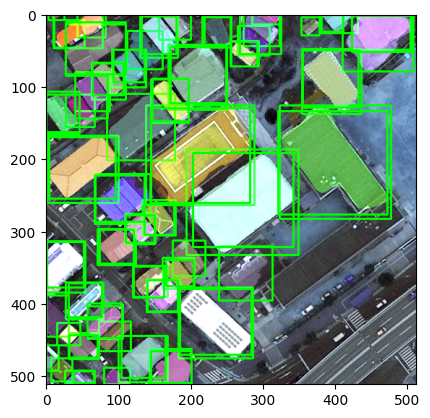

In [27]:
# Draw each bounding box
for bbox in boxes_numpy:
    x_min, y_min, x_max, y_max = bbox.astype(np.int32)
    cv2.rectangle(im, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # Green box, 2px thickness

# Display the image with bounding boxes
plt.imshow(im)
plt.show()
